In [1]:
from scipy.sparse import csr_matrix
from math import ceil, floor

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

In [2]:
data_jan = pd.read_csv("yellow_tripdata_2016-01.csv")
data_feb = pd.read_csv("yellow_tripdata_2016-02.csv")
data_mar = pd.read_csv("yellow_tripdata_2016-03.csv")
data = pd.concat([data_jan, data_feb, data_mar])
# data = pd.concat([data_jan, data_feb])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34499859 entries, 0 to 12210951
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RatecodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 5.1+ GB


In [3]:
data.drop([
    'VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 
    'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount'], 
    axis=1,
    inplace = True
)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34499859 entries, 0 to 12210951
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   trip_distance          float64
 3   pickup_longitude       float64
 4   pickup_latitude        float64
 5   dropoff_longitude      float64
 6   dropoff_latitude       float64
 7   fare_amount            float64
dtypes: float64(6), object(2)
memory usage: 2.3+ GB


In [4]:
# filter the data by latitude, longitude
import json
manhattan_boundary = json.load(open('manhattan.geojson', 'r'))
coords = manhattan_boundary['features'][0]['geometry']['coordinates'][0]

min_lon = min([lon for lon, _ in coords])
max_lon = max([lon for lon, _ in coords])
min_lat = min([lat for _, lat in coords])
max_lat = max([lat for _, lat in coords])

data = data[(data["pickup_latitude"] >= min_lat) & (data["pickup_latitude"] <= max_lat) &
                (data["pickup_longitude"] >= min_lon) & (data["pickup_longitude"] <= max_lon) &
                (data["dropoff_latitude"] >= min_lat) & (data["dropoff_latitude"] <= max_lat) &
                (data["dropoff_longitude"] >= min_lon) & (data["dropoff_longitude"] <= max_lon)]

In [5]:
# filter data by fare_amount
print("99.9% of the fare amounts are less than: ", data["fare_amount"].quantile(q=0.999), "dollars")
data = data[(data["fare_amount"] > 0) & (data["fare_amount"] < 53)]

99.9% of the fare amounts are less than:  52.0 dollars


In [6]:
# filter data by trip_distance
print("99.9% of the rip distances are less than: ", data["trip_distance"].quantile(q=0.999), "miles")
data = data[(data["trip_distance"] > 0) & (data["trip_distance"] < 12)]

99.9% of the rip distances are less than:  11.11 miles


In [7]:
data['tpep_pickup_datetime']= pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime']= pd.to_datetime(data['tpep_dropoff_datetime']) 

data["trip_duration"] = (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds()
print("99.9% of the trip duratins are less than: ", data["trip_duration"].quantile(q=0.999), "seconds")
data = data[(data["trip_duration"] > 0) & (data["trip_duration"] < 24*3600) ]

99.9% of the trip duratins are less than:  85476.82400000468 seconds


In [8]:
data["speed"] = data["trip_distance"] / (data["trip_duration"] / 3600)
print("99.9% of the trip speeds are less than: ", data["speed"].quantile(q=0.999), "mph")
data = data[(data["speed"] > 0) & (data["speed"] < 60)]

99.9% of the trip speeds are less than:  36.87055476529161 mph


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29889639 entries, 5 to 12210943
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   trip_distance          float64       
 3   pickup_longitude       float64       
 4   pickup_latitude        float64       
 5   dropoff_longitude      float64       
 6   dropoff_latitude       float64       
 7   fare_amount            float64       
 8   trip_duration          float64       
 9   speed                  float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 2.4 GB


In [60]:
import pickle
pickle.dump(data, open('temp_data/filtered_data.pickle', 'wb'))

In [4]:
import pickle
data = pickle.load(open('filtered_data.pickle', 'rb'))

import json
manhattan_boundary = json.load(open('manhattan.geojson', 'r'))
coords = manhattan_boundary['features'][0]['geometry']['coordinates'][0]

min_lon = min([lon for lon, _ in coords])
max_lon = max([lon for lon, _ in coords])
min_lat = min([lat for _, lat in coords])
max_lat = max([lat for _, lat in coords])

In [5]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R = 6371.0 * c # 6371 radius of the earth in km
    return km * 1000


In [6]:
grid_side_length = 300  # 300m
time_interval_length = 20  # 20 min

width = haversine_np(min_lon, min_lat, max_lon, min_lat)
height = haversine_np(min_lon, min_lat, min_lon, max_lat)

print(width, height)

H = ceil(height / grid_side_length)
W = ceil(width / grid_side_length)

print(H, W, H*W)

bottom_left_lon = np.array([min_lon] * data.shape[0])
bottom_left_lat = np.array([min_lat] * data.shape[0])
min_timestamp = pd.Timestamp('2016-01-01 00:00:00')


def set_grid_index(data):
    src_x = haversine_np(bottom_left_lon, bottom_left_lat, data["pickup_longitude"], bottom_left_lat)
    src_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["pickup_latitude"])

    src_x = np.floor(src_x / grid_side_length)
    src_y = np.floor(src_y / grid_side_length)
    data["pickup_grid"] = src_y * W + src_x
    data["pickup_grid_x"] = src_x
    data["pickup_grid_y"] = src_y

    dest_x = haversine_np(bottom_left_lon, bottom_left_lat, data["dropoff_longitude"], bottom_left_lat)
    dest_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["dropoff_latitude"])
    dest_x = np.floor(dest_x / grid_side_length)
    dest_y = np.floor(dest_y / grid_side_length)
    data["dropoff_grid"] = dest_y * W + dest_x
    data["dropoff_grid_x"] = dest_x
    data["dropoff_grid_y"] = dest_y


def set_timeinterval_index(data):
    time_delta_minutes = (data["tpep_pickup_datetime"] - min_timestamp).dt.total_seconds() / 60
    data["pickup_timeinterval_index"] = np.floor(time_delta_minutes / time_interval_length)
    
    time_delta_minutes = (data["tpep_dropoff_datetime"] - min_timestamp).dt.total_seconds() / 60
    data["dropoff_timeinterval_index"] = np.floor(time_delta_minutes / time_interval_length)

10303.529670673082 19914.53188192843
67 35 2345


In [7]:
set_grid_index(data)
set_timeinterval_index(data)
data = data.astype({
    'pickup_grid': 'int32',
    'pickup_grid_x': 'int32',
    'pickup_grid_y': 'int32',
    'dropoff_grid': 'int32',
    'dropoff_grid_x': 'int32',
    'dropoff_grid_y': 'int32',
    'pickup_timeinterval_index': 'int32',
    'dropoff_timeinterval_index': 'int32'
})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29889482 entries, 5 to 12210943
Data columns (total 19 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   tpep_pickup_datetime        datetime64[ns]
 1   tpep_dropoff_datetime       datetime64[ns]
 2   passenger_count             int64         
 3   trip_distance               float64       
 4   pickup_longitude            float64       
 5   pickup_latitude             float64       
 6   dropoff_longitude           float64       
 7   dropoff_latitude            float64       
 8   fare_amount                 float64       
 9   trip_duration               float64       
 10  speed                       float64       
 11  pickup_grid                 int32         
 12  pickup_grid_x               int32         
 13  pickup_grid_y               int32         
 14  dropoff_grid                int32         
 15  dropoff_grid_x              int32         
 16  dropoff_grid_y  

In [92]:
data.sort_values(by='tpep_dropoff_datetime', ascending=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,trip_duration,speed,pickup_grid,pickup_grid_x,pickup_grid_y,dropoff_grid,dropoff_grid_x,dropoff_grid_y,pickup_timeinterval_index,dropoff_timeinterval_index
12209107,2016-03-31 23:53:55,2016-04-01 23:51:49,2.51,-73.999725,40.731182,-73.980072,40.760113,10.0,86274.0,0.104736,392,7,11,783,13,22,6551,6623
12207170,2016-03-31 23:48:08,2016-04-01 23:47:03,3.96,-73.987778,40.721241,-73.954132,40.770302,16.0,86335.0,0.165124,291,11,8,930,20,26,6551,6623
12208554,2016-03-31 23:52:18,2016-04-01 23:43:40,1.46,-73.976868,40.748909,-73.988159,40.732040,7.0,85882.0,0.061200,644,14,18,430,10,12,6551,6623
12205709,2016-03-31 23:43:47,2016-04-01 23:39:17,0.85,-73.977997,40.725403,-73.988258,40.720055,6.5,86130.0,0.035528,328,13,9,255,10,7,6551,6622
12201637,2016-03-31 23:32:00,2016-04-01 23:30:19,2.67,-73.977715,40.745529,-73.955490,40.778637,12.0,86299.0,0.111380,608,13,17,1035,20,29,6550,6622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2016-01-01 00:00:14,2016-01-01 00:02:38,0.44,-73.990273,40.772011,-73.995041,40.769772,4.0,144.0,11.000000,920,10,26,884,9,25,0,0
137,2016-01-01 00:01:27,2016-01-01 00:02:33,0.10,-73.955177,40.773174,-73.956230,40.772038,3.0,66.0,5.454545,965,20,27,929,19,26,0,0
27,2016-01-01 00:00:10,2016-01-01 00:02:20,0.87,-73.954407,40.778069,-73.948929,40.788582,4.5,130.0,24.092308,1035,20,29,1142,22,32,0,0
28,2016-01-01 00:00:12,2016-01-01 00:01:17,0.13,-73.991653,40.754559,-73.990601,40.756119,3.0,65.0,7.200000,710,10,20,710,10,20,0,0


In [8]:
graph_data = data[
    ["pickup_grid", "pickup_grid_x", "pickup_grid_y", 
     "dropoff_grid", "dropoff_grid_x", "dropoff_grid_y", 
     "pickup_timeinterval_index", "dropoff_timeinterval_index"]
]
max_timeinterval_index = max(graph_data["pickup_timeinterval_index"])+1
number_of_nodes = H*W

pickup_counts = np.zeros((number_of_nodes, max_timeinterval_index))
dropoff_counts = np.zeros_like(pickup_counts)

# A tensor: channel x height x width
# width: number of grids in x axis
# height: number of grids in y axis
# number of channels: number of time intervals
# cell value: pickup / dropoff counts
grid_pickup_counts = np.zeros((max_timeinterval_index, H, W))
grid_dropoff_counts = np.zeros_like(grid_pickup_counts)

pickup_grid_time_count = graph_data.groupby(['pickup_timeinterval_index', 'pickup_grid', 'pickup_grid_x', 'pickup_grid_y'])\
                            ['dropoff_grid'].count().reset_index(name='count')

# pickup_grid_time_count
pickup_counts[
    pickup_grid_time_count['pickup_grid'],
    pickup_grid_time_count['pickup_timeinterval_index']
] = pickup_grid_time_count['count'].values

grid_pickup_counts[
    pickup_grid_time_count['pickup_timeinterval_index'],
    pickup_grid_time_count['pickup_grid_y'], 
    pickup_grid_time_count['pickup_grid_x']
] = pickup_grid_time_count['count'].values


dropoff_grid_time_count = graph_data[graph_data.dropoff_timeinterval_index < max_timeinterval_index]\
                            .groupby(['dropoff_timeinterval_index', 'dropoff_grid', 'dropoff_grid_x', 'dropoff_grid_y'])\
                            ['pickup_grid'].count().reset_index(name='count')

# dropoff_grid_time_count
dropoff_counts[
    dropoff_grid_time_count['dropoff_grid'],
    dropoff_grid_time_count['dropoff_timeinterval_index']
] = dropoff_grid_time_count['count'].values

grid_dropoff_counts[
    dropoff_grid_time_count['dropoff_timeinterval_index'],
    dropoff_grid_time_count['dropoff_grid_y'], 
    dropoff_grid_time_count['dropoff_grid_x']
] = dropoff_grid_time_count['count'].values

grid_pickup_counts = torch.Tensor(grid_pickup_counts)
grid_dropoff_counts = torch.Tensor(grid_dropoff_counts)

In [30]:
from scipy import fft
sig_fft = fft.fft(pickup_counts)
sig_fft_real = 2 * np.abs(sig_fft / pickup_counts.shape[1])
sig_freqs = fft.fftfreq(pickup_counts.shape[1], 1 / (24 * 3))

print(sig_fft_real.shape, sig_freqs.shape)

pos_freq_mask = sig_freqs > 0

sig_freqs_masked = np.tile(sig_freqs[pos_freq_mask], (number_of_nodes, 1))
pos_freq_mask = np.tile(pos_freq_mask, (number_of_nodes, 1))
sig_fft_real_masked = sig_fft_real[pos_freq_mask].reshape(number_of_nodes, -1)
sig_freqs_masked.shape, sig_fft_real_masked.shape

#pick the 10 largest freqquencies
k=8
k_largest_indices = np.argpartition(sig_freqs_masked, k)
fourier_amplitudes = sig_fft_real_masked[:, -k:]
fourier_frequencies = sig_freqs_masked[:, -k:]

# fourier_amplitudes.shape, fourier_frequencies.shape
fourier_features = np.hstack((fourier_amplitudes, fourier_frequencies))
fourier_features.shape

(2345, 6552) (6552,)


(2345, 16)

In [38]:
fourier_reshaped = torch.Tensor(fourier_features).view((H, W, -1)).permute(2, 0, 1)
# (fourier_reshaped[0][0] == torch.Tensor(fourier_features[0])).all()
# (fourier_reshaped == torch.Tensor(fourier_features).reshape((-1, H, W))).all()
(fourier_reshaped.view((-1, H*W)).permute(1, 0) == torch.Tensor(fourier_features)).all()

tensor(True)

In [31]:
def get_time_features(timeIntervalIndex, number_of_nodes):
    # hour of day, day of week: will be same for all nodes in the particular time interval
    time_interval_starting_timestamp = min_timestamp + timeIntervalIndex * pd.Timedelta('%s minutes' % time_interval_length)
    hour_of_day = time_interval_starting_timestamp.hour
    day_of_week = time_interval_starting_timestamp.dayofweek
    month_of_year = time_interval_starting_timestamp.month - 1
    
    # print(hour_of_day, day_of_week, month_of_year)
    
    hour = np.zeros((number_of_nodes, 24))
    hour[:, hour_of_day] = 1
    
    day = np.zeros((number_of_nodes, 7))
    day[:, day_of_week] = 1
    
    month = np.zeros((number_of_nodes, 12))
    month[:, month_of_year] = 1
    
    #return np.hstack((hour, day, month))
    return np.hstack((hour, day))

In [34]:
'''
feature dimensions:
hour_of_day: possible values are 0-23, Dimension in one hot encoding = 24
day of week: possible values: 0-6, Dimension in one hot encoding = 7
month of year: possible values: 0-11, Dimension in one hot encoding = 12
pickup count history: Dimension 's'
weighted moving avergae of pickup count: Dimension 1
dropoff count history: 2 hours data, 2*3 = 6 timeinterval data, Dimesion 6
fourier frequencies: Dimension 96
fourier amplitudes: Dimension 96
Total Dimension: (24 + 7 + 12 + s + 1 + 6 + 96 * 2)
'''

s = 5
train_start_index = s * 7 * 24 * 3
# fourier_features = torch.Tensor(fourier_features).reshape((H, W, -1)).permute(2, 0, 1)

# feature_dimension = 24 + 7 + 12 + s + 1 + 6 + fourier_features.shape[1]
# feature_dimension = 24 + 7 + 12 + s*2 + s*2 + fourier_features.shape[1]
demand_feature_dimension = 2 * s + 2 * s + 2 * s
feature_dimension = 24 + 7 + fourier_features.shape[0] + 2 * s + 2 * s + 2 * s

time_feature_dimension = 24 + 7
time_features = torch.zeros((max_timeinterval_index, number_of_nodes, time_feature_dimension))

demand_features = torch.zeros((max_timeinterval_index, demand_feature_dimension, H, W))
# other_features = torch.zeros((max_timeinterval_index, feature_dimension - demand_feature_dimension, H, W))

for t in range(train_start_index, max_timeinterval_index):
    # print('time interval index: %s/%s' % (t, max_timeinterval_index))
    X_time_features = get_time_features(t, number_of_nodes)
    # X_time_features = torch.Tensor(X_time_features).view((H, W, -1)).permute(2, 0, 1)
    time_features[t] = torch.Tensor(X_time_features)
    # print(X_time_features.shape)
    
    # Gather recent and spatially proximate features
    recent_pickup_features = grid_pickup_counts[t-s:t]  # shape: channels(last 5 timeindices) x height x width
    recent_dropoff_features = grid_dropoff_counts[t-s:t]  # shape: channels(last 5 timeindices) x height x width
    # print(recent_pickup_features.shape, recent_dropoff_features.shape)
    
    # gather pickups,dropoff history in recent days
    past_pickup_features = grid_pickup_counts[range(t-s*24*3, t, 24*3)]  # shape: channels(last 5 timeindices) x height x width
    past_dropoff_features = grid_dropoff_counts[range(t-s*24*3, t, 24*3)]  # shape: channels(last 5 timeindices) x height x width
    
    # historical pickup,dropoff feature
    pickup_history_features = grid_pickup_counts[range(t-s*7*24*3, t, 7*24*3)]
    dropoff_history_features = grid_dropoff_counts[range(t-s*7*24*3, t, 7*24*3)]
    # print(pickup_history_features.shape, dropoff_history_features.shape)
    # print(pickup_count_features.shape, dropoff_count_features.shape, X_time_features.shape, fourier_features.shape)
    
    demand_features[t] = torch.cat((
        recent_pickup_features,
        recent_dropoff_features,
        past_pickup_features,
        past_dropoff_features,
        pickup_history_features,
        dropoff_history_features
    ))
    

demand_features = demand_features.view((max_timeinterval_index, -1, H*W)).permute(0, 2, 1)
# fourier_features = torch.Tensor(fourier_features).reshape((H, W, -1)).permute(2, 0, 1)
print(demand_features.shape, fourier_features.shape, time_features.shape)

torch.Size([6552, 2345, 30]) torch.Size([2345, 16]) torch.Size([6552, 2345, 31])


In [35]:
# normalize the features
train_start_index = s * 7 * 24 * 3
dataset_size = len(range(train_start_index, max_timeinterval_index))
train_size = int(dataset_size * 0.8)

demand_scaler = StandardScaler()
fourier_scaler = StandardScaler()
time_scaler = StandardScaler()

fourier_scaler.fit(fourier_features)
fourier_features = torch.Tensor(fourier_scaler.transform(fourier_features))

# scale data using only the training data
for t in range(train_start_index, train_start_index + train_size):
    demand_scaler.partial_fit(demand_features[t])
    time_scaler.partial_fit(time_features[t])
    
for t in range(train_start_index, max_timeinterval_index):
    demand_features[t] = torch.Tensor(demand_scaler.transform(demand_features[t]))
    time_features[t] = torch.Tensor(time_scaler.transform(time_features[t]))
    
    
# fix dimension for CNN
demand_features = demand_features.permute(0, 2, 1).view((max_timeinterval_index, -1, H, W))
fourier_features = torch.Tensor(fourier_features).reshape((H, W, -1)).permute(2, 0, 1)
time_features = time_features.permute(0, 2, 1).view((max_timeinterval_index, -1, H, W))
print(demand_features.shape, fourier_features.shape, time_features.shape)

torch.Size([6552, 30, 67, 35]) torch.Size([16, 67, 35]) torch.Size([6552, 31, 67, 35])


In [36]:
target_values = torch.Tensor(pickup_counts.T)

In [37]:
# Design a dataloader

dataset = TensorDataset(
    demand_features[train_start_index:, ],
    time_features[train_start_index:, ],
    target_values[train_start_index:, ]
)

train_dataset, val_dataset = Subset(dataset, range(train_size)), Subset(dataset, range(train_size, len(dataset)))

train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False, pin_memory=False)
val_dataloader = DataLoader(val_dataset, batch_size=None, shuffle=False, pin_memory=False)

print(len(train_dataloader), len(val_dataloader))

3225 807


In [41]:
class CNN(nn.Module):
    def __init__(self, demand_feature_length, fourier_feature_length, time_feature_length):
        super(CNN, self).__init__()
        
        self.conv_demand = nn.Conv2d(in_channels=demand_feature_length, out_channels=32, kernel_size=3, padding=1)
        self.relu_demand = nn.ReLU()
        
        self.conv_fourier = nn.Conv2d(in_channels=fourier_feature_length, out_channels=32, kernel_size=3, padding=1)
        self.relu_fourier = nn.ReLU()
        
        self.fc1 = nn.Linear(in_features=64+time_feature_length, out_features=32)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(in_features=16, out_features=1)
        self.relu3 = nn.ReLU()
            
    def forward(self, x_demand, x_fourier, x_time):
        x_demand = self.relu_demand(self.conv_demand(x_demand))
        x_fourier = self.relu_fourier(self.conv_fourier(x_fourier))
        #print(x_demand.shape, x_other.shape)
        x = torch.cat([x_demand, x_fourier, x_time], dim=1)
        # print(x.shape)
        x = torch.squeeze(x).permute(1, 2, 0).view(number_of_nodes, -1)
        # print(x.shape)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        # print(x.shape)
        return x

In [45]:
model = CNN(demand_feature_length=demand_feature_dimension, fourier_feature_length=16, time_feature_length=31)

for i, (demand_feature, time_feature, target_value) in enumerate(train_dataloader):
    print(demand_feature.shape, time_feature.shape, target_value.shape)
    demand_feature = torch.unsqueeze(demand_feature, dim=0)
    fourier_feature = torch.unsqueeze(fourier_features, dim=0)
    time_feature = torch.unsqueeze(time_feature, dim=0)
    output = model(demand_feature, fourier_feature, time_feature)
    print(output.shape)
    break

torch.Size([30, 67, 35]) torch.Size([31, 67, 35]) torch.Size([2345])
torch.Size([2345, 1])


In [47]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

learning_rate = 0.005

model = CNN(demand_feature_length=demand_feature_dimension, fourier_feature_length=16, time_feature_length=31)
model.cuda()

fourier_feature = torch.unsqueeze(fourier_features, dim=0).cuda()

optimizer = optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=5e-4
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

In [50]:
def train(demand_feature, fourier_feature, time_feature, target_value):
    model.train()
    optimizer.zero_grad()
    output = model(demand_feature, fourier_feature, time_feature)
    loss_train = F.mse_loss(output, target_value)
    loss_train.backward()
    optimizer.step()
    mae_loss = F.l1_loss(output, target_value)
    rmsle_loss = torch.sqrt(F.mse_loss(torch.log(output + 1), torch.log(target_value + 1)))
    # print(rmsle_loss.shape, rmsle_loss)
    return loss_train.item(), mae_loss.item(), rmsle_loss.item()

# Train model
def train_model(number_of_epochs):
    train_losses_by_epoch = []
    val_losses_by_epoch = []
    for epoch in range(number_of_epochs):
        train_losses = []
        train_mae_losses = []
        train_rmsle_losses = []
        for i, (demand_feature, time_feature, target_value) in enumerate(train_dataloader):
            demand_feature = torch.unsqueeze(demand_feature, dim=0).cuda()
            time_feature = torch.unsqueeze(time_feature, dim=0).cuda()
            #fourier_feature = torch.unsqueeze(fourier_features, dim=0).cuda()
            target_value = target_value.reshape(number_of_nodes, -1).cuda()
            loss, mae_loss, rmsle_loss = train(demand_feature, fourier_feature, time_feature, target_value)
            train_losses.append(loss)
            train_mae_losses.append(mae_loss)
            train_rmsle_losses.append(rmsle_loss)
            # if (i % 500 == 0): print('i=',i,'train rmse loss', np.mean(np.sqrt(train_losses)))
            
        mean_train_loss = np.mean(np.sqrt(train_losses))
        mean_val_loss, mean_val_mae_loss, mean_val_rmsle_loss = get_validation_loss()
        
        train_losses_by_epoch.append((mean_train_loss, np.mean(train_mae_losses), np.mean(train_rmsle_losses)))
        val_losses_by_epoch.append((mean_val_loss, mean_val_mae_loss, mean_val_rmsle_loss))
        
        print(
            'Epoch: {:04d}'.format(epoch+1),
            'train rmse loss: {:.4f}'.format(mean_train_loss),
            'val rmse loss: {:.4f}'.format(mean_val_loss)
        )
        scheduler.step(mean_train_loss)
    return train_losses_by_epoch, val_losses_by_epoch


def get_validation_loss():
    val_losses = []
    val_mae_losses = []
    val_rmsle_losses = []
    for i, (demand_feature, time_feature, target_value) in enumerate(val_dataloader):
        model.eval()
        demand_feature = torch.unsqueeze(demand_feature, dim=0).cuda()
        time_feature = torch.unsqueeze(time_feature, dim=0).cuda()
        target_value = target_value.reshape(number_of_nodes, -1).cuda()
        output = model(demand_feature, fourier_feature, time_feature)
        loss_val = F.mse_loss(output, target_value)
        mae_loss_val = F.l1_loss(output, target_value)
        rmsle_loss = torch.sqrt(F.mse_loss(torch.log(output + 1), torch.log(target_value + 1)))
        # print(rmsle_loss)
        val_losses.append(loss_val.item())
        val_mae_losses.append(mae_loss_val.item())
        val_rmsle_losses.append(rmsle_loss.item())
        
    return np.mean(np.sqrt(val_losses)), np.mean(val_mae_losses), np.mean(val_rmsle_losses)

In [51]:
train_losses, val_losses = train_model(number_of_epochs=100)

Epoch: 0001 train rmse loss: 1.9985 val rmse loss: 1.9185
Epoch: 0002 train rmse loss: 1.9004 val rmse loss: 1.8574
Epoch: 0003 train rmse loss: 1.8658 val rmse loss: 1.8184
Epoch: 0004 train rmse loss: 1.8469 val rmse loss: 1.8319
Epoch: 0005 train rmse loss: 1.8358 val rmse loss: 1.8140
Epoch: 0006 train rmse loss: 1.8248 val rmse loss: 1.7972
Epoch: 0007 train rmse loss: 1.8209 val rmse loss: 1.8136
Epoch: 0008 train rmse loss: 1.8178 val rmse loss: 1.7724
Epoch: 0009 train rmse loss: 1.8175 val rmse loss: 1.7975
Epoch: 0010 train rmse loss: 1.8199 val rmse loss: 1.7904
Epoch: 0011 train rmse loss: 1.8124 val rmse loss: 1.7698
Epoch: 0012 train rmse loss: 1.8124 val rmse loss: 1.7670
Epoch: 0013 train rmse loss: 1.8256 val rmse loss: 1.7819
Epoch: 0014 train rmse loss: 1.8091 val rmse loss: 1.7475
Epoch: 0015 train rmse loss: 1.8173 val rmse loss: 1.7776
Epoch: 0016 train rmse loss: 1.8081 val rmse loss: 1.7700
Epoch: 0017 train rmse loss: 1.8114 val rmse loss: 1.7709
Epoch: 0018 tr

In [20]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11777

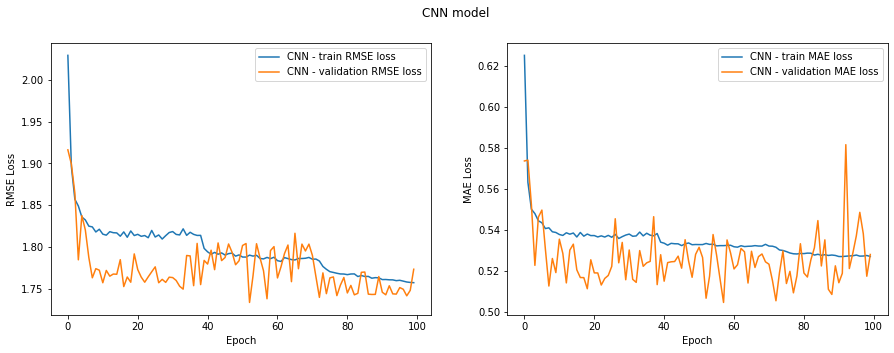

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex=True)
fig.suptitle('CNN model')
ax1.plot(range(100), [mse_loss for mse_loss, _, _ in train_losses], label='CNN - train RMSE loss')
ax1.plot(range(100), [mse_loss for mse_loss, _, _ in val_losses], label='CNN - validation RMSE loss')
ax2.plot(range(100), [mae_loss for _, mae_loss, _ in train_losses], label='CNN - train MAE loss')
ax2.plot(range(100), [mae_loss for _, mae_loss, _ in val_losses], label='CNN - validation MAE loss')
ax1.set_ylabel('RMSE Loss')
ax2.set_ylabel('MAE Loss')
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.legend()
ax2.legend()
fig.savefig("cnn_model_3x3_results_new.png", bbox_inches='tight', dpi=600)

In [52]:
min([mse_loss for mse_loss, _, _ in val_losses])

1.7364807479633981

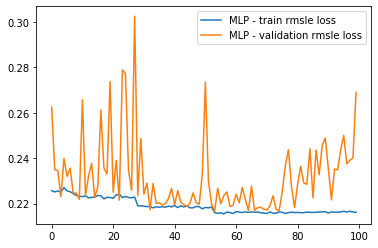

In [53]:
plt.plot(range(100), [rmsle_loss for _, _, rmsle_loss in train_losses], label='MLP - train rmsle loss')
plt.plot(range(100), [rmsle_loss for _, _, rmsle_loss in val_losses], label='MLP - validation rmsle loss')
plt.legend()

In [23]:
# !mkdir CNN_model_results
import pickle
torch.save(model.state_dict(), 'cnn_model_3x3_demand_conv_only.pt')
pickle.dump(train_losses, open('train_losses_3x3_demand_conv_only.pickle', 'wb'))
pickle.dump(val_losses, open('val_losses_3x3_demand_conv_only.pickle', 'wb'))

In [1]:
import pickle
train_losses = pickle.load(open('train_losses_3x3.pickle', 'rb'))
val_losses = pickle.load(open('val_losses_3x3.pickle', 'rb'))

In [2]:
min([mse_loss for mse_loss, _, _ in val_losses])

1.740097730344259

In [3]:
min([mse_loss for _, mse_loss, _ in val_losses])

0.5037758678954921